In [1]:
import numpy as np
import math
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import cartopy
import cartopy.crs as ccrs
import metpy.calc as mpcalc
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import pop_tools 
import matplotlib.path as mpath
import dask
import utils
import pandas as pd

import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cartopy.feature as cfeature

### Define case, path, and box regions

In [2]:
case = 'g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001'
path = '/glade/derecho/scratch/kristenk/hi-res-proc'
variables = ['POC_FLUX_100m', 'photoC_cocco_zint','photoC_diaz_zint',
             'photoC_sp_zint','photoC_diat_zint','TEMP'] #,'coccoC'] will just use coccoNPP instead of coccoC

# coords = {'x':'TLONG','y':'TLAT'}
# keep_vars = variables + list(coords.values())+['dz','KMT']
# path

In [3]:
ds_grid = pop_tools.get_grid('POP_tx0.1v3')

area = ds_grid.TAREA
lats = ds_grid.TLAT
lons = ds_grid.TLONG
lons_norm = utils.normal_lons(lons)

In [4]:
ds_grid

<xarray.Dataset>
Dimensions:      (nlat: 2400, nlon: 3600, z_t: 62, z_w: 62, z_w_bot: 62)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05 5.75e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5.5e+05 5.75e+05 6e+05
Dimensions without coordinates: nlat, nlon
Data variables: (12/13)
    TLAT         (nlat, nlon) float64 -71.08 -71.08 -71.08 ... 62.34 62.34 62.34
    TLONG        (nlat, nlon) float64 250.0 250.2 250.2 ... 250.0 250.0 250.0
    ULAT         (nlat, nlon) float64 -78.45 -78.45 -78.45 ... 62.34 62.34 62.34
    ULONG        (nlat, nlon) float64 -109.9 -109.8 -109.7 ... -110.0 -110.0
    DXT          (nlat, nlon) float64 1.116e+05 1.122e+05 ... 2.042e+03 927.1
    DYT          (nlat, nlon) float64 4.699e+05 4.699e+05 ... 1.664e+03 794.8
    ...           ...
    DYU          (nlat, nlon) float64 4.699e+05 4.699e+05 ... 2.351e+05
    TAREA        (nlat, nlon) float64 5.244e+10 5.274e+10 ... 7.369e+05
    UAREA        (nlat, nlon) float64 1.046e+11 1.046e+11 ... 1.495e+08
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.5e+04 2.5e+04 2.5e+04
Attributes:
    lateral_dims:       [2400, 3600]
    vertical_dims:      62
    vert_grid_file:     tx0.1v3_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/tx0.1v3/grid/horiz_grid_200709.ieeer8
    topography_fname:   inputdata/ocn/pop/tx0.1v3/grid/topography_20170718.ie...
    region_mask_fname:  inputdata/ocn/pop/tx0.1v3/grid/region_mask_20170718.i...
    type:               tripole
    title:              POP_tx0.1v3 grid

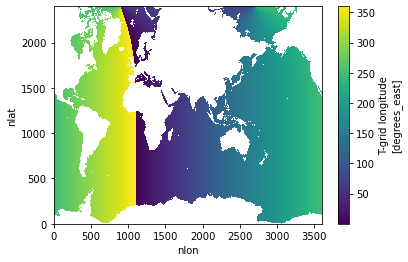

In [5]:
lons.where(ds_grid.REGION_MASK>0).plot()

In [6]:
### Box1: Fig 10, NW Pacific, use lons to mask [-225, -135, 25, 60]
box1_latmin = 25
box1_latmax = 60
box1_lonmin = 135
box1_lonmax = 225

### Box2: Fig 11, N Pacific, use lons to mask [-220, -115, 30, 60]
box2_latmin = 30
box2_latmax = 60
box2_lonmin = 140
box2_lonmax = 255

### Box3: Fig 13, N Atlantic, use lons_norm to mask [-60, -7, 40, 67]
box3_latmin = 40
box3_latmax = 67
box3_lonmin = -60
box3_lonmax = -7

### Box4: Fig 14, Eq Pac, (ds_grid_01.TLONG > 180) & (ds_grid_01.TLONG.values < 250) & (ds_grid_01.TLAT < 10) & (ds_grid_01.TLAT > -10)
box4_latmin = -10
box4_latmax = 10
box4_lonmin = 180
box4_lonmax = 250

### Box5: Fig 14, Amundsen-bellinghausen region of the SO, [-130, -60, -90, -65]
box5_latmin = -85
box5_latmax = -65
box5_lonmin = -130
box5_lonmax = -60

### Box 6, Little box in South indian ocean
box6_latmin = -50
box6_latmax = -44
box6_lonmin = 82.
box6_lonmax = 93.

#### Make sure masking works

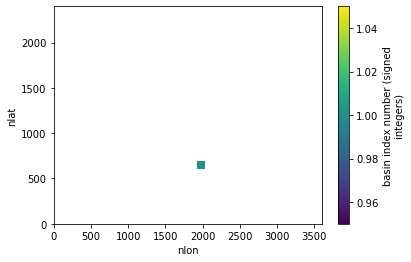

In [7]:
#test = ds_grid.REGION_MASK.where(lats<box1_latmax).where(lats>box1_latmin).where(lons<box1_lonmax).where(lons>box1_lonmin)
#test = ds_grid.REGION_MASK.where(lats<box2_latmax).where(lats>box2_latmin).where(lons<box2_lonmax).where(lons>box2_lonmin)
#test = ds_grid.REGION_MASK.where(lats<box3_latmax).where(lats>box3_latmin).where(lons_norm<box3_lonmax).where(lons_norm>box3_lonmin)
#test = ds_grid.REGION_MASK.where(lats<box4_latmax).where(lats>box4_latmin).where(lons<box4_lonmax).where(lons>box4_lonmin)
#test = ds_grid.REGION_MASK.where(lats<box5_latmax).where(lats>box5_latmin).where(lons_norm<box5_lonmax).where(lons_norm>box5_lonmin)
test = ds_grid.REGION_MASK.where(lats<box6_latmax).where(lats>box6_latmin).where(lons_norm<box6_lonmax).where(lons_norm>box6_lonmin)


test.plot()

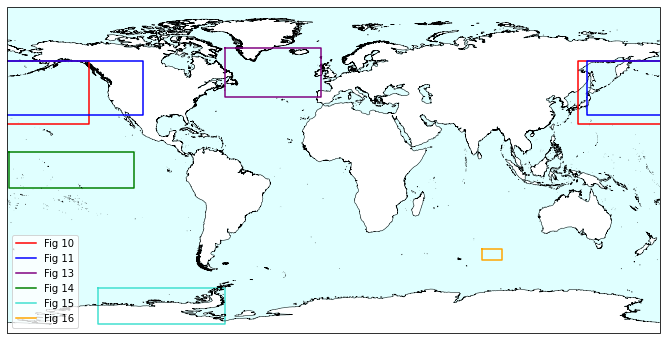

In [8]:
fig = plt.figure(figsize=(12,6))


############################
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor='lightcyan'), zorder=0)

# boxes
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="red", linewidth=1.5,transform=ccrs.PlateCarree(), label='Fig 10')

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="blue", linewidth=1.5,transform=ccrs.PlateCarree(), label='Fig 11')

lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color="purple", linewidth=1.5,transform=ccrs.PlateCarree(), label='Fig 13')

lon_pts = [box4_lonmin+1,box4_lonmax,box4_lonmax,box4_lonmin+1,box4_lonmin+1] #adding one just for plotting purposes
lat_pts = [box4_latmax,box4_latmax,box4_latmin,box4_latmin,box4_latmax]
ax.plot(lon_pts, lat_pts, color="green", linewidth=1.5,transform=ccrs.PlateCarree(), label='Fig 14', zorder=1)

lon_pts = [box5_lonmin,box5_lonmax,box5_lonmax,box5_lonmin,box5_lonmin]
lat_pts = [box5_latmax,box5_latmax,box5_latmin,box5_latmin,box5_latmax]
ax.plot(lon_pts, lat_pts, color="turquoise", linewidth=1.5,transform=ccrs.PlateCarree(), label='Fig 15', zorder=1)

lon_pts = [box6_lonmin,box6_lonmax,box6_lonmax,box6_lonmin,box6_lonmin]
lat_pts = [box6_latmax,box6_latmax,box6_latmin,box6_latmin,box6_latmax]
ax.plot(lon_pts, lat_pts, color="orange", linewidth=1.5,transform=ccrs.PlateCarree(), label='Fig 16', zorder=1)

ax.legend()

### get monthly data and immediately convert it to annual

In [9]:
def preprocess(ds):
    ds=ds.isel(z_t=0)
    ds=ds.isel(z_t_150m=0)
    return ds

### Initialize timeseries arrays

In [10]:
ds_box1 = xr.Dataset()
ds_box2 = xr.Dataset()
ds_box3 = xr.Dataset()
ds_box4 = xr.Dataset()
ds_box5 = xr.Dataset()
ds_box6 = xr.Dataset()

In [11]:
ds_box5_djf = xr.Dataset()
ds_box6_djf = xr.Dataset()

### Make mask files

In [12]:
ones = np.full((2400,3600),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))
ones = ones.where(ds_grid.REGION_MASK>0)

In [13]:
mask1 = ones.where(lats<box1_latmax).where(lats>box1_latmin).where(lons<box1_lonmax).where(lons>box1_lonmin)
mask2 = ones.where(lats<box2_latmax).where(lats>box2_latmin).where(lons<box2_lonmax).where(lons>box2_lonmin)
mask3 = ones.where(lats<box3_latmax).where(lats>box3_latmin).where(lons_norm<box3_lonmax).where(lons_norm>box3_lonmin)
mask4 = ones.where(lats<box4_latmax).where(lats>box4_latmin).where(lons<box4_lonmax).where(lons>box4_lonmin)
mask5 = ones.where(lats<box5_latmax).where(lats>box5_latmin).where(lons_norm<box5_lonmax).where(lons_norm>box5_lonmin)
mask6 = ones.where(lats<box6_latmax).where(lats>box6_latmin).where(lons_norm<box6_lonmax).where(lons_norm>box6_lonmin)

In [14]:
area_mask1 = area.where(mask1==1)
area_mask2 = area.where(mask2==1)
area_mask3 = area.where(mask3==1)
area_mask4 = area.where(mask4==1)
area_mask5 = area.where(mask5==1)
area_mask6 = area.where(mask6==1)

In [15]:
%%time

for v in variables: 
    i = 0
    print(v)

    var_array1 = np.zeros([64])
    var_array2 = np.zeros([64])
    var_array3 = np.zeros([64])
    var_array4 = np.zeros([64])
    var_array5 = np.zeros([64])
    var_array6 = np.zeros([64])
    
    for year in np.arange(1958,2022,1):

        yr4="{:04d}".format(year)
        #print(year)
        
        if v=='TEMP':
            files = f'{path}/{case}.{v}_surf.{yr4}.nc'
            dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                           drop_variables=["transport_components", "transport_regions"], decode_times=True)
        else:
            files = f'{path}/{case}.{v}.{yr4}.nc'
            dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                           drop_variables=["transport_components", "transport_regions"], decode_times=True)

        ### make box means for this variable

        #box 1
        masked_fosi = dsv[v].where(mask1==1)
        var_array1[i] = (masked_fosi * area_mask1).sum(dim=('nlon','nlat')) / area_mask1.sum(dim=('nlon','nlat'))

        #box 2
        masked_fosi = dsv[v].where(mask2==1)
        var_array2[i] = (masked_fosi * area_mask2).sum(dim=('nlon','nlat')) / area_mask2.sum(dim=('nlon','nlat'))

        #box 3
        masked_fosi = dsv[v].where(mask3==1)
        var_array3[i] = (masked_fosi * area_mask3).sum(dim=('nlon','nlat')) / area_mask3.sum(dim=('nlon','nlat'))

        #box 4
        masked_fosi = dsv[v].where(mask4==1)
        var_array4[i] = (masked_fosi * area_mask4).sum(dim=('nlon','nlat')) / area_mask4.sum(dim=('nlon','nlat'))

        #box 5
        masked_fosi = dsv[v].where(mask5==1)
        var_array5[i] = (masked_fosi * area_mask5).sum(dim=('nlon','nlat')) / area_mask5.sum(dim=('nlon','nlat'))

        #box 6
        masked_fosi = dsv[v].where(mask6==1)
        var_array6[i] = (masked_fosi * area_mask6).sum(dim=('nlon','nlat')) / area_mask6.sum(dim=('nlon','nlat'))
        
        i = i + 1
        
    ds_box1[v] = xr.DataArray(var_array1,dims=('time'))
    ds_box2[v] = xr.DataArray(var_array2,dims=('time'))
    ds_box3[v] = xr.DataArray(var_array3,dims=('time'))
    ds_box4[v] = xr.DataArray(var_array4,dims=('time'))
    ds_box5[v] = xr.DataArray(var_array5,dims=('time'))
    ds_box6[v] = xr.DataArray(var_array6,dims=('time'))



POC_FLUX_100m
photoC_cocco_zint
photoC_diaz_zint
photoC_sp_zint
photoC_diat_zint
TEMP
CPU times: user 8min 26s, sys: 2min 23s, total: 10min 50s
Wall time: 12min 30s


### Do the DJF ones

In [16]:
variables = ['photoC_cocco_zint','photoC_diaz_zint',
             'photoC_sp_zint','photoC_diat_zint','TEMP']

In [17]:
%%time

for v in variables: 
    i = 0
    print(v)

    var_array5 = np.zeros([63])
    var_array6 = np.zeros([63])
    
    for year in np.arange(1958,2021,1):

        yr4="{:04d}".format(year)
        print(year)
        
        if v=='TEMP':
            files = f'{path}/{case}.{v}.DJF-{yr4}.nc'
            dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                           drop_variables=["transport_components", "transport_regions"], decode_times=True)
        else:
            files = f'{path}/{case}.{v}.DJF-{yr4}.nc'
            dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                           drop_variables=["transport_components", "transport_regions"], decode_times=True)

        ### make box means for this variable

       
        #box 5
        masked_fosi = dsv[v].where(mask5==1)
        var_array5[i] = (masked_fosi * area_mask5).sum(dim=('nlon','nlat')) / area_mask5.sum(dim=('nlon','nlat'))

        #box 6
        masked_fosi = dsv[v].where(mask6==1)
        var_array6[i] = (masked_fosi * area_mask6).sum(dim=('nlon','nlat')) / area_mask6.sum(dim=('nlon','nlat'))
        
        i = i + 1
        print(year)
    print('make it into a xr')
    ds_box5_djf[v] = xr.DataArray(var_array5,dims=('time'))
    ds_box6_djf[v] = xr.DataArray(var_array6,dims=('time'))



photoC_cocco_zint
1958
1958
1959
1959
1960
1960
1961
1961
1962
1962
1963
1963
1964
1964
1965
1965
1966
1966
1967
1967
1968
1968
1969
1969
1970
1970
1971
1971
1972
1972
1973
1973
1974
1974
1975
1975
1976
1976
1977
1977
1978
1978
1979
1979
1980
1980
1981
1981
1982
1982
1983
1983
1984
1984
1985
1985
1986
1986
1987
1987
1988
1988
1989
1989
1990
1990
1991
1991
1992
1992
1993
1993
1994
1994
1995
1995
1996
1996
1997
1997
1998
1998
1999
1999
2000
2000
2001
2001
2002
2002
2003
2003
2004
2004
2005
2005
2006
2006
2007
2007
2008
2008
2009
2009
2010
2010
2011
2011
2012
2012
2013
2013
2014
2014
2015
2015
2016
2016
2017
2017
2018
2018
2019
2019
2020
2020
make it into a xr
photoC_diaz_zint
1958
1958
1959
1959
1960
1960
1961
1961
1962
1962
1963
1963
1964
1964
1965
1965
1966
1966
1967
1967
1968
1968
1969
1969
1970
1970
1971
1971
1972
1972
1973
1973
1974
1974
1975
1975
1976
1976
1977
1977
1978
1978
1979
1979
1980
1980
1981
1981
1982
1982
1983
1983
1984
1984
1985
1985
1986
1986
1987
1987
1988
1988
1989
19

### Now get the fish and make a new fish ds for each box

In [31]:
tot_fish_box1 = np.zeros([42]) #total fish biomass from 1980 to 2021
tot_fish_box2 = np.zeros([42])
tot_fish_box3 = np.zeros([42])
tot_fish_box4 = np.zeros([42])
tot_fish_box5 = np.zeros([42])
tot_fish_box6 = np.zeros([42])

i = 0

path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001/FEISTY'

######### loop start here

for year in np.arange(1980,2022,1):
    
    yr4="{:04d}".format(year)
    
    file = f'{path}/FEISTY-hi-res-x0.1-{yr4}.nc'
            
    ds_feisty_x01=xr.open_dataset(file)
    
    ds_tmp = xr.Dataset()
    
    ds_tmp['Pelagics'] = ds_feisty_x01.biomass.sel(group='Lp') + ds_feisty_x01.biomass.sel(group='Mp') + ds_feisty_x01.biomass.sel(group='Sp')
    ds_tmp['Forages'] = ds_feisty_x01.biomass.sel(group='Mf') + ds_feisty_x01.biomass.sel(group='Sf')
    ds_tmp['Demersals'] = ds_feisty_x01.biomass.sel(group='Ld') + ds_feisty_x01.biomass.sel(group='Md') + ds_feisty_x01.biomass.sel(group='Sd')
    
    tot_fish_2d = ds_tmp['Pelagics'] + ds_tmp['Forages'] + ds_tmp['Demersals']
    
    ## mask out crazy values
    tot_fish_2d = tot_fish_2d.where(tot_fish_2d<1000).where(tot_fish_2d>-100)
    
    area_mask1['nlat'] = tot_fish_2d.nlat
    area_mask1['nlon'] = tot_fish_2d.nlon
    
    area_mask2['nlat'] = tot_fish_2d.nlat
    area_mask2['nlon'] = tot_fish_2d.nlon
    
    area_mask3['nlat'] = tot_fish_2d.nlat
    area_mask3['nlon'] = tot_fish_2d.nlon
    
    area_mask4['nlat'] = tot_fish_2d.nlat
    area_mask4['nlon'] = tot_fish_2d.nlon
    
    area_mask5['nlat'] = tot_fish_2d.nlat
    area_mask5['nlon'] = tot_fish_2d.nlon
    
    area_mask6['nlat'] = tot_fish_2d.nlat
    area_mask6['nlon'] = tot_fish_2d.nlon

    #box 1
    masked_fosi = tot_fish_2d.where(mask1==1)
    tmp = (masked_fosi * area_mask1).sum(dim=('nlon','nlat')) / area_mask1.sum(dim=('nlon','nlat'))
    tot_fish_box1[i] = tmp.values
    #box 2
    masked_fosi = tot_fish_2d.where(mask2==1)
    tmp = (masked_fosi * area_mask2).sum(dim=('nlon','nlat')) / area_mask2.sum(dim=('nlon','nlat'))
    tot_fish_box2[i] = tmp.values
    #box 3
    masked_fosi = tot_fish_2d.where(mask3==1)
    tmp = (masked_fosi * area_mask3).sum(dim=('nlon','nlat')) / area_mask3.sum(dim=('nlon','nlat'))
    tot_fish_box3[i] = tmp.values
    #box 4
    masked_fosi = tot_fish_2d.where(mask4==1)
    tmp = (masked_fosi * area_mask4).sum(dim=('nlon','nlat')) / area_mask4.sum(dim=('nlon','nlat'))
    tot_fish_box4[i] = tmp.values
    #box 5
    masked_fosi = tot_fish_2d.where(mask5==1)
    tmp = (masked_fosi * area_mask5).sum(dim=('nlon','nlat')) / area_mask5.sum(dim=('nlon','nlat'))
    tot_fish_box5[i] = tmp.values
    #box 6
    masked_fosi = tot_fish_2d.where(mask6==1)
    tmp = (masked_fosi * area_mask6).sum(dim=('nlon','nlat')) / area_mask6.sum(dim=('nlon','nlat'))
    tot_fish_box6[i] = tmp.values
    
    i = i + 1

tot_fish_box1 = xr.DataArray(tot_fish_box1, dims=('time'))
tot_fish_box2 = xr.DataArray(tot_fish_box2, dims=('time'))
tot_fish_box3 = xr.DataArray(tot_fish_box3, dims=('time'))
tot_fish_box4 = xr.DataArray(tot_fish_box4, dims=('time'))
tot_fish_box5 = xr.DataArray(tot_fish_box5, dims=('time'))
tot_fish_box6 = xr.DataArray(tot_fish_box6, dims=('time'))
                             

In [32]:
tot_fish_box1['time'] = np.arange(1980,2022,1)
tot_fish_box2['time'] = np.arange(1980,2022,1)
tot_fish_box3['time'] = np.arange(1980,2022,1)
tot_fish_box4['time'] = np.arange(1980,2022,1)
tot_fish_box5['time'] = np.arange(1980,2022,1)
tot_fish_box6['time'] = np.arange(1980,2022,1)

### Now do DJF fish

In [27]:
tot_fish_box5_djf = np.zeros([41])
tot_fish_box6_djf = np.zeros([41])

i = 0

path = '/glade/derecho/scratch/kristenk/hi-res-proc'

######### loop start here

for year in np.arange(1980,2021,1):
    
    yr4="{:04d}".format(year)
    
    file = f'{path}/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001.FEISTY.DJF-{yr4}.nc'
            
    ds_feisty_x01=xr.open_dataset(file)
    
    ds_tmp = xr.Dataset()
    
    ds_tmp['Pelagics'] = ds_feisty_x01.biomass.sel(group='Lp') + ds_feisty_x01.biomass.sel(group='Mp') + ds_feisty_x01.biomass.sel(group='Sp')
    ds_tmp['Forages'] = ds_feisty_x01.biomass.sel(group='Mf') + ds_feisty_x01.biomass.sel(group='Sf')
    ds_tmp['Demersals'] = ds_feisty_x01.biomass.sel(group='Ld') + ds_feisty_x01.biomass.sel(group='Md') + ds_feisty_x01.biomass.sel(group='Sd')
    
    tot_fish_2d = ds_tmp['Pelagics'] + ds_tmp['Forages'] + ds_tmp['Demersals']
    
    ## mask out crazy values
    tot_fish_2d = tot_fish_2d.where(tot_fish_2d<1000).where(tot_fish_2d>-100)
    
    area_mask1['nlat'] = tot_fish_2d.nlat
    area_mask1['nlon'] = tot_fish_2d.nlon
    
    area_mask2['nlat'] = tot_fish_2d.nlat
    area_mask2['nlon'] = tot_fish_2d.nlon
    
    area_mask3['nlat'] = tot_fish_2d.nlat
    area_mask3['nlon'] = tot_fish_2d.nlon
    
    area_mask4['nlat'] = tot_fish_2d.nlat
    area_mask4['nlon'] = tot_fish_2d.nlon
    
    area_mask5['nlat'] = tot_fish_2d.nlat
    area_mask5['nlon'] = tot_fish_2d.nlon
    
    area_mask6['nlat'] = tot_fish_2d.nlat
    area_mask6['nlon'] = tot_fish_2d.nlon

    #box 5
    masked_fosi = tot_fish_2d.where(mask5==1)
    tmp = (masked_fosi * area_mask5).sum(dim=('nlon','nlat')) / area_mask5.sum(dim=('nlon','nlat'))
    tot_fish_box5_djf[i] = tmp.values
    
    #box 6
    masked_fosi = tot_fish_2d.where(mask6==1)
    tmp = (masked_fosi * area_mask6).sum(dim=('nlon','nlat')) / area_mask6.sum(dim=('nlon','nlat'))
    tot_fish_box6_djf[i] = tmp.values
    
    i = i + 1

tot_fish_box5_djf = xr.DataArray(tot_fish_box5_djf, dims=('time'))
tot_fish_box6_djf = xr.DataArray(tot_fish_box6_djf, dims=('time'))
                             

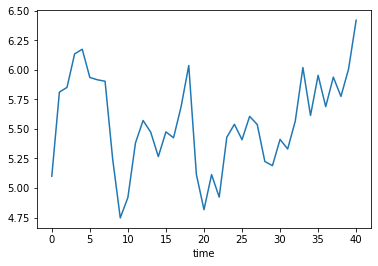

In [28]:
tot_fish_box6_djf.plot()

### Total up NPP

In [21]:
ds_box1['NPP'] = ds_box1.photoC_cocco_zint + ds_box1.photoC_diat_zint + ds_box1.photoC_diaz_zint + ds_box1.photoC_sp_zint
ds_box2['NPP'] = ds_box2.photoC_cocco_zint + ds_box2.photoC_diat_zint + ds_box2.photoC_diaz_zint + ds_box2.photoC_sp_zint
ds_box3['NPP'] = ds_box3.photoC_cocco_zint + ds_box3.photoC_diat_zint + ds_box3.photoC_diaz_zint + ds_box3.photoC_sp_zint
ds_box4['NPP'] = ds_box4.photoC_cocco_zint + ds_box4.photoC_diat_zint + ds_box4.photoC_diaz_zint + ds_box4.photoC_sp_zint
ds_box5['NPP'] = ds_box5.photoC_cocco_zint + ds_box5.photoC_diat_zint + ds_box5.photoC_diaz_zint + ds_box5.photoC_sp_zint
ds_box6['NPP'] = ds_box6.photoC_cocco_zint + ds_box6.photoC_diat_zint + ds_box6.photoC_diaz_zint + ds_box6.photoC_sp_zint

In [22]:
ds_box5_djf['NPP'] = ds_box5_djf.photoC_cocco_zint + ds_box5_djf.photoC_diat_zint + ds_box5_djf.photoC_diaz_zint + ds_box5_djf.photoC_sp_zint
ds_box6_djf['NPP'] = ds_box6_djf.photoC_cocco_zint + ds_box6_djf.photoC_diat_zint + ds_box6_djf.photoC_diaz_zint + ds_box6_djf.photoC_sp_zint

### Layout the figure

In [23]:
import matplotlib.gridspec as gridspec

In [24]:
ds_box1['time'] = np.arange(1958,2022,1)
ds_box2['time'] = np.arange(1958,2022,1)
ds_box3['time'] = np.arange(1958,2022,1)
ds_box4['time'] = np.arange(1958,2022,1)
ds_box5['time'] = np.arange(1958,2022,1)
ds_box6['time'] = np.arange(1958,2022,1)

In [25]:
ds_box5_djf['time'] = np.arange(1958,2021,1)
ds_box6_djf['time'] = np.arange(1958,2021,1)

In [51]:
tot_fish_box5_djf['time'] = np.arange(1980,2021,1)
tot_fish_box6_djf['time'] = np.arange(1980,2021,1)

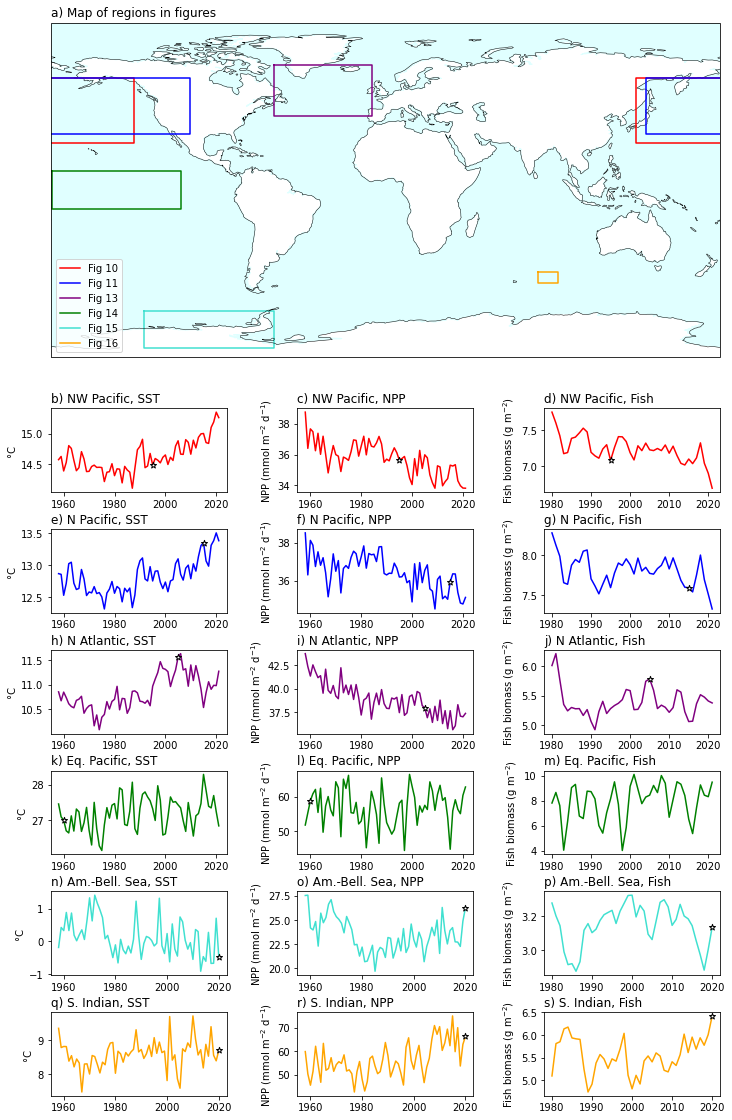

In [60]:
fig = plt.figure(figsize=(12, 20))

gs = gridspec.GridSpec(nrows=7, ncols=3, width_ratios=(1,1,1), height_ratios=(1.3,0.3,0.3,0.3,0.3,0.3,0.3))

prj = ccrs.PlateCarree() #ccrs.Robinson(central_longitude=305.0)

ax_map = plt.subplot(gs[0,0:3], projection=prj)

ax_box1_sst = plt.subplot(gs[1,0])
ax_box1_npp = plt.subplot(gs[1,1])
ax_box1_fish = plt.subplot(gs[1,2])

ax_box2_sst = plt.subplot(gs[2,0])
ax_box2_npp = plt.subplot(gs[2,1])
ax_box2_fish = plt.subplot(gs[2,2])

ax_box3_sst = plt.subplot(gs[3,0])
ax_box3_npp = plt.subplot(gs[3,1])
ax_box3_fish = plt.subplot(gs[3,2])

ax_box4_sst = plt.subplot(gs[4,0])
ax_box4_npp = plt.subplot(gs[4,1])
ax_box4_fish = plt.subplot(gs[4,2])

ax_box5_sst = plt.subplot(gs[5,0])
ax_box5_npp = plt.subplot(gs[5,1])
ax_box5_fish = plt.subplot(gs[5,2])

ax_box6_sst = plt.subplot(gs[6,0])
ax_box6_npp = plt.subplot(gs[6,1])
ax_box6_fish = plt.subplot(gs[6,2])

########## MAP
ax_map.set_title('a) Map of regions in figures',loc='left')
ax_map.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax_map.coastlines('110m',linewidth=0.5)
ax_map.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor='lightcyan'), zorder=0)

# boxes
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax_map.plot(lon_pts, lat_pts, color="red", linewidth=1.5,transform=ccrs.PlateCarree(), label='Fig 10')

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax_map.plot(lon_pts, lat_pts, color="blue", linewidth=1.5,transform=ccrs.PlateCarree(), label='Fig 11')

lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax_map.plot(lon_pts, lat_pts, color="purple", linewidth=1.5,transform=ccrs.PlateCarree(), label='Fig 13')

lon_pts = [box4_lonmin+1,box4_lonmax,box4_lonmax,box4_lonmin+1,box4_lonmin+1] #adding one just for plotting purposes
lat_pts = [box4_latmax,box4_latmax,box4_latmin,box4_latmin,box4_latmax]
ax_map.plot(lon_pts, lat_pts, color="green", linewidth=1.5,transform=ccrs.PlateCarree(), label='Fig 14', zorder=1)

lon_pts = [box5_lonmin,box5_lonmax,box5_lonmax,box5_lonmin,box5_lonmin]
lat_pts = [box5_latmax,box5_latmax,box5_latmin,box5_latmin,box5_latmax]
ax_map.plot(lon_pts, lat_pts, color="turquoise", linewidth=1.5,transform=ccrs.PlateCarree(), label='Fig 15', zorder=1)

lon_pts = [box6_lonmin,box6_lonmax,box6_lonmax,box6_lonmin,box6_lonmin]
lat_pts = [box6_latmax,box6_latmax,box6_latmin,box6_latmin,box6_latmax]
ax_map.plot(lon_pts, lat_pts, color="orange", linewidth=1.5,transform=ccrs.PlateCarree(), label='Fig 16', zorder=1)

ax_map.legend()

#### BOX 1

ax_box1_sst.set_title('b) NW Pacific, SST',loc='left')
ax_box1_sst.plot(ds_box1.time, ds_box1.TEMP,color='red',zorder=0)
ax_box1_sst.scatter(ds_box1.time[37], ds_box1.TEMP[37],s=40,color='white',edgecolor='black',marker='*',zorder=1)
ax_box1_sst.set(ylabel='°C'); #xlabel='year',

ax_box1_npp.set_title('c) NW Pacific, NPP',loc='left')
ax_box1_npp.plot(ds_box1.time, ds_box1.NPP*0.01*86400.,color='red',zorder=0)
ax_box1_npp.scatter(ds_box1.time[37], ds_box1.NPP[37]*0.01*86400.,s=40,color='white',edgecolor='black',marker='*',zorder=1)
ax_box1_npp.set(ylabel='NPP (mmol m$^{-2}$ d$^{-1}$)'); #xlabel='year',

ax_box1_fish.set_title('d) NW Pacific, Fish',loc='left')
ax_box1_fish.plot(tot_fish_box1.time, tot_fish_box1, color='red',zorder=0)
ax_box1_fish.scatter(tot_fish_box1.time[15], tot_fish_box1[15],s=40,color='white',edgecolor='black',marker='*',zorder=1)
ax_box1_fish.set(ylabel='Fish biomass (g m$^{-2}$)'); #xlabel='year',


#### BOX 2

ax_box2_sst.set_title('e) N Pacific, SST',loc='left')
ax_box2_sst.plot(ds_box2.time, ds_box2.TEMP,color='blue',zorder=0)
ax_box2_sst.scatter(ds_box2.time[57], ds_box2.TEMP[57],s=40,color='white',edgecolor='black',marker='*',zorder=1)
ax_box2_sst.set(ylabel='°C'); #xlabel='year',

ax_box2_npp.set_title('f) N Pacific, NPP',loc='left')
ax_box2_npp.plot(ds_box2.time, ds_box2.NPP*0.01*86400.,color='blue',zorder=0)
ax_box2_npp.scatter(ds_box2.time[57], ds_box2.NPP[57]*0.01*86400.,s=40,color='white',edgecolor='black',marker='*',zorder=1)
ax_box2_npp.set(ylabel='NPP (mmol m$^{-2}$ d$^{-1}$)'); #xlabel='year',

ax_box2_fish.set_title('g) N Pacific, Fish',loc='left')
ax_box2_fish.plot(tot_fish_box2.time, tot_fish_box2, color='blue',zorder=0)
ax_box2_fish.scatter(tot_fish_box2.time[35], tot_fish_box2[35],s=40,color='white',edgecolor='black',marker='*',zorder=1)
ax_box2_fish.set(ylabel='Fish biomass (g m$^{-2}$)'); #xlabel='year',


#### BOX 3

ax_box3_sst.set_title('h) N Atlantic, SST',loc='left')
ax_box3_sst.plot(ds_box3.time, ds_box3.TEMP,color='purple',zorder=0)
ax_box3_sst.scatter(ds_box3.time[47], ds_box3.TEMP[47],s=40,color='white',edgecolor='black',marker='*',zorder=1)
ax_box3_sst.set(ylabel='°C'); #xlabel='year',

ax_box3_npp.set_title('i) N Atlantic, NPP',loc='left')
ax_box3_npp.plot(ds_box3.time, ds_box3.NPP*0.01*86400.,color='purple',zorder=0)
ax_box3_npp.scatter(ds_box3.time[47], ds_box3.NPP[47]*0.01*86400.,s=40,color='white',edgecolor='black',marker='*',zorder=1)
ax_box3_npp.set(ylabel='NPP (mmol m$^{-2}$ d$^{-1}$)'); #xlabel='year',

ax_box3_fish.set_title('j) N Atlantic, Fish',loc='left')
ax_box3_fish.plot(tot_fish_box3.time, tot_fish_box3, color='purple',zorder=0)
ax_box3_fish.scatter(tot_fish_box3.time[25], tot_fish_box3[25],s=40,color='white',edgecolor='black',marker='*',zorder=1)
ax_box3_fish.set(ylabel='Fish biomass (g m$^{-2}$)'); #xlabel='year',


#### BOX 4

ax_box4_sst.set_title('k) Eq. Pacific, SST',loc='left')
ax_box4_sst.plot(ds_box4.time, ds_box4.TEMP,color='green',zorder=0)
ax_box4_sst.scatter(ds_box4.time[2], ds_box4.TEMP[2],s=40,color='white',edgecolor='black',marker='*',zorder=1)
ax_box4_sst.set(ylabel='°C'); #xlabel='year',

ax_box4_npp.set_title('l) Eq. Pacific, NPP',loc='left')
ax_box4_npp.plot(ds_box4.time, ds_box4.NPP*0.01*86400.,color='green',zorder=0)
ax_box4_npp.scatter(ds_box4.time[2], ds_box4.NPP[2]*0.01*86400.,s=40,color='white',edgecolor='black',marker='*',zorder=1)
ax_box4_npp.set(ylabel='NPP (mmol m$^{-2}$ d$^{-1}$)'); #xlabel='year',

ax_box4_fish.set_title('m) Eq. Pacific, Fish',loc='left')
ax_box4_fish.plot(tot_fish_box4.time, tot_fish_box4, color='green',zorder=0)
#ax_box4_fish.scatter(tot_fish_box4.time[25], tot_fish_box4[25],s=30,color='black',marker='*',zorder=1)
ax_box4_fish.set(ylabel='Fish biomass (g m$^{-2}$)'); #xlabel='year',


#### BOX 5 - DJF

ax_box5_sst.set_title('n) Am.-Bell. Sea, SST',loc='left')
ax_box5_sst.plot(ds_box5_djf.time, ds_box5_djf.TEMP,color='turquoise',zorder=0)
ax_box5_sst.scatter(ds_box5_djf.time[62], ds_box5_djf.TEMP[62],s=40,color='white',edgecolor='black',marker='*',zorder=1)
ax_box5_sst.set(ylabel='°C'); #xlabel='year',

ax_box5_npp.set_title('o) Am.-Bell. Sea, NPP',loc='left')
ax_box5_npp.plot(ds_box5_djf.time, ds_box5_djf.NPP*0.01*86400.,color='turquoise',zorder=0)
ax_box5_npp.scatter(ds_box5_djf.time[62], ds_box5_djf.NPP[62]*0.01*86400.,s=40,color='white',edgecolor='black',marker='*',zorder=1)
ax_box5_npp.set(ylabel='NPP (mmol m$^{-2}$ d$^{-1}$)'); #xlabel='year',

ax_box5_fish.set_title('p) Am.-Bell. Sea, Fish',loc='left')
ax_box5_fish.plot(tot_fish_box5_djf.time, tot_fish_box5_djf, color='turquoise',zorder=0)
ax_box5_fish.scatter(tot_fish_box5_djf.time[40], tot_fish_box5_djf[40],s=40,color='white',edgecolor='black',marker='*',zorder=1)
ax_box5_fish.set(ylabel='Fish biomass (g m$^{-2}$)'); #xlabel='year',

#### BOX 6 - DJF

ax_box6_sst.set_title('q) S. Indian, SST',loc='left')
ax_box6_sst.plot(ds_box6_djf.time, ds_box6_djf.TEMP,color='orange',zorder=0)
ax_box6_sst.scatter(ds_box6_djf.time[62], ds_box6_djf.TEMP[62],s=40,color='white',edgecolor='black',marker='*',zorder=1)
ax_box6_sst.set(ylabel='°C'); #xlabel='year',

ax_box6_npp.set_title('r) S. Indian, NPP',loc='left')
ax_box6_npp.plot(ds_box6_djf.time, ds_box6_djf.NPP*0.01*86400.,color='orange',zorder=0)
ax_box6_npp.scatter(ds_box6_djf.time[62], ds_box6_djf.NPP[62]*0.01*86400.,s=40,color='white',edgecolor='black',marker='*',zorder=1)
ax_box6_npp.set(ylabel='NPP (mmol m$^{-2}$ d$^{-1}$)'); #xlabel='year',

ax_box6_fish.set_title('s) S. Indian, Fish',loc='left')
ax_box6_fish.plot(tot_fish_box6_djf.time, tot_fish_box6_djf, color='orange',zorder=0)
ax_box6_fish.scatter(tot_fish_box6_djf.time[40], tot_fish_box6_djf[40],s=40,color='white',edgecolor='black',marker='*',zorder=1)
ax_box6_fish.set(ylabel='Fish biomass (g m$^{-2}$)'); #xlabel='year',

fig.subplots_adjust(wspace=0.4,hspace=0.3)

fig.savefig('/glade/work/kristenk/figs/FigS1-regional_timeseries_FOSI-HR.png', bbox_inches='tight', dpi=300, format='png');

In [45]:
ds_box1.time[62]

<xarray.DataArray 'time' ()>
array(2020)
Coordinates:
    time     int64 2020

In [46]:
tot_fish_box1.time[40]

<xarray.DataArray 'time' ()>
array(2020)
Coordinates:
    time     int64 2020